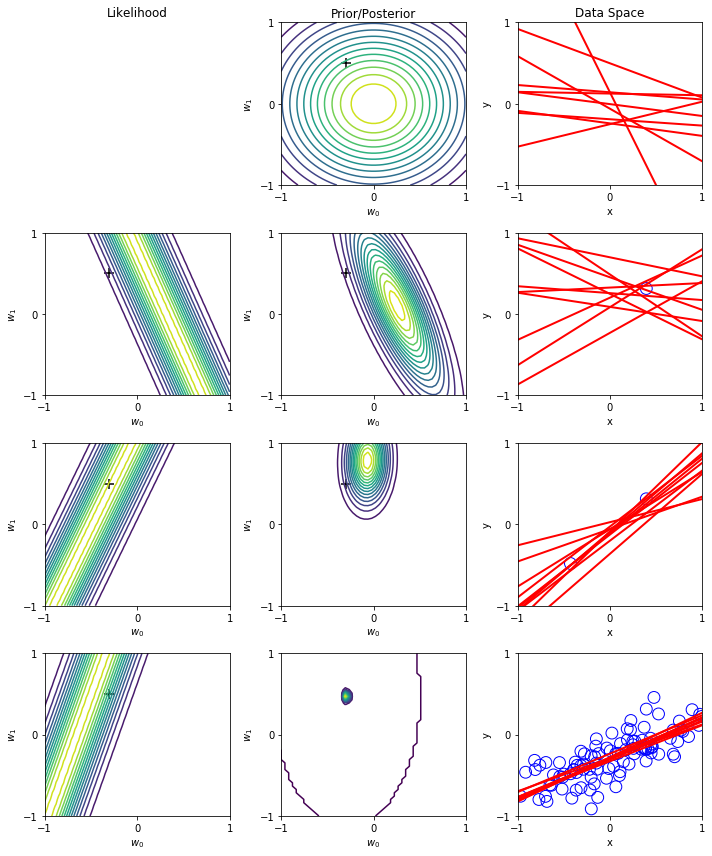

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal
np.random.seed(123)
# Number of samples to draw from posterior distribution of parameters.
NSamples = 10
# Each of these corresponds to a row in the graphic and an amount of 
# data the posterior will reflect.
# First one must be zero, for the prior.
DataIndices = [0,1,2,100] 
# True regression parameters that we wish to recover. 
# Do not set these outside the range of [-1,1]
a0 = -0.3
a1 = 0.5
NPoints = 100 #Number of (x,y) training points
noiseSD = 0.2 #True noise standard deviation
priorPrecision = 2.0 #Fix the prior precision, alpha. 
                     # We will use a zero-mean isotropic Gaussian.
likelihoodSD = noiseSD # Assume the likelihood precision, beta, is known.
likelihoodPrecision = 1.0/(likelihoodSD**2)
#x and y values should be in the same range as the coefficients.
x = 2*uniform().rvs(NPoints) - 1
y = a0 + a1*x + norm(0, noiseSD).rvs(NPoints) 
#
def MeanCovPost(x, y):
    #Given data vectors x and y, this returns the posterior mean and covariance.
    X = np.array([[1,x1] for x1 in x])
    Precision = np.diag([priorPrecision]*2) + likelihoodPrecision*X.T.dot(X)
    Cov = np.linalg.inv(Precision)
    Mean = likelihoodPrecision*Cov.dot(X.T.dot(y))
    return {'Mean':Mean,'Cov':Cov}
#    
def GaussPdfMaker(mean,cov):
    #For a given (mean, cov) pair, this returns a vectorized pdf function.
    def out(w1,w2):
        return multivariate_normal.pdf([w1,w2],mean=mean,cov=cov)
    return np.vectorize(out)
#
def LikeFMaker(x0,y0):
    #For a given (x,y) pair, this returns a vectorized likelhood function.
    def out(w1,w2):
        err = y0 - (w1 + w2*x0) 
        return norm.pdf(err,loc=0,scale=likelihoodSD)
    return np.vectorize(out)
#
# Grid space for which values will be determined, 
# which is shared between the coefficient space and data space.
grid = np.linspace(-1,1,50)
Xg = np.array([[1,g] for g in grid])
G1, G2 = np.meshgrid(grid,grid)
# If we have many samples of lines, we make them a bit transparent.
alph = 5.0/NSamples if NSamples>50 else  1.0 
# A function to make some common adjustments to our subplots.
def adjustgraph(whitemark):
    if whitemark:
        plt.ylabel(r'$w_1$')
        plt.xlabel(r'$w_0$')
        #plt.scatter(a0,a1,marker='+',color='white',s=100)
        plt.scatter(a0,a1,marker='+',color='black',s=100)
    else:
        plt.ylabel('y')
        plt.xlabel('x')
    plt.ylim([-1,1])    
    plt.xlim([-1,1])
    plt.xticks([-1,0,1])
    plt.yticks([-1,0,1])    
    return None
#
figcounter = 1
fig = plt.figure(figsize=(10,12))
# Top left plot only has a title.
ax = fig.add_subplot(len(DataIndices),3,figcounter)
ax.set_title('Likelihood')
plt.axis('off')
# This builds the graph one row at a time.
for di in DataIndices:
    if di == 0:
        postM = [0,0]
        postCov = np.diag([1.0/priorPrecision]*2)
    else:
        Post = MeanCovPost(x[:di],y[:di])
        postM = Post['Mean']
        postCov = Post['Cov']
        # Left graph
        figcounter += 1
        fig.add_subplot(len(DataIndices),3,figcounter)
        likfunc = LikeFMaker(x[di-1],y[di-1])
        #plt.contourf(G1, G2, likfunc(G1,G2), 100)
        plt.contour(G1, G2, likfunc(G1,G2), 15)
        adjustgraph(True)
    # Middle graph
    postfunc = GaussPdfMaker(postM,postCov)
    figcounter += 1
    ax = fig.add_subplot(len(DataIndices),3,figcounter)
    #plt.contourf(G1, G2, postfunc(G1,G2), 100)
    plt.contour(G1, G2, postfunc(G1,G2), 15)
    adjustgraph(True)
    # Set title if this is the top middle graph
    if figcounter == 2:
        ax.set_title('Prior/Posterior')
    # Right graph    
    Samples = multivariate_normal(postM,postCov).rvs(NSamples)
    Lines = Xg.dot(Samples.T)
    figcounter += 1
    ax = fig.add_subplot(len(DataIndices),3,figcounter)
    if di != 0:
        plt.scatter(x[:di],y[:di], s=140, facecolors='none', edgecolors='b')
    for j in range(Lines.shape[1]):
        plt.plot(grid,Lines[:,j],linewidth=2,color='r',alpha=alph)
    # Set title if this is the top right graph
    if figcounter == 3:
        ax.set_title('Data Space')
    adjustgraph(False)
fig.tight_layout()

<Figure size 432x288 with 0 Axes>